In [140]:
#pip install spotipy --upgrade              # Uncomment this and run it if you haven't installed spotipy before


In [141]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import re, glob
import os, sys
from scipy import stats

import spotipy                          # Set up a config file with ckey and skey. These are available if you go
from spotipy.oauth2 import SpotifyClientCredentials      # to https://developer.spotify.com/, click on Dashboard 
                                        # from the horizontal black menu, login with your normal user info. Click 
# Import Keys                           # on "create an app" if you haven't yet, it doesn't matter what you call it.
from config import ckey, skey           # Then click into
                                        # your project and you should see Client ID and Client Secret. Those are your 
                                        # ckey and skey. 

In [142]:
# Setting up Spotify API info

client_credentials_manager = SpotifyClientCredentials(client_id=ckey, client_secret=skey)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



TIP: This next section assumes that you have already downloaded the csv files with the Top200 charts for the country you are working on:

1. Create a subfolder in the folder this notebook is located in called "input_files". Add the owid-covid-data.csv file there, you'll need that later. Then make another subfolder inside input_files called "spotify_top200_charts". Save the csv files you download there. 
2. Go to https://spotifycharts.com
2. Choose the country you want to work on. 
3. Download Weekly Top200 charts for 2019 and 2020, 1 chart per month. We agreed as a group to download the chart from last week of each month, to keep things consistent. Save them in the "spotify_top200_charts" folder you set up. 

In [143]:
# Create dataframe from weekly chart data


path = r"input_files/spotify_top200_charts/*.csv"                    # The path requires "".csv" at end of file name. 
                                                                 # This is to prevent the program from blowing up
                                                                 # when it hits some kind of hidden file. 

country_tracks_df = pd.read_csv(glob.glob(path)[0], header=1)    # Sets up main dataframe with data from FIRST file
string = str(glob.glob(path)[0])                                 # in the folder.
year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)   # This line extracts the year and month from the 
country_tracks_df[['Year']] = year_month[0]                      # file name, and sets up new columns called 'Year'
country_tracks_df[['Month']] = year_month[1]                     # and 'Month' with that info. 

for file in glob.glob(path)[1:]:                                 # Now that you have the dataframe set up from the 
        temp_df = pd.read_csv(file, header=1)                    # first file in the folder, this iterates through 
        string = str(file)                                       # remaining files
        year_month, = re.findall(r"ly-(\d\d\d\d)-(\d\d)-\d\d", string)
        #print (year_month)
        temp_df[['Year']] = year_month[0]
        temp_df[['Month']] = year_month[1]
        country_tracks_df = pd.concat([country_tracks_df,        # Adds temperary datafame to end of main dataframe
                                       temp_df])                 # as new rows.       
                                                 
country_tracks_df = country_tracks_df.sort_values(['Year','Month'])  # Sort the new dataframe by year and month

country_tracks_df                                                # You should get 4,800 rows (24 months x 200 
                                                                 # tracks per month)

,Position,Track Name,Artist,Streams,URL,Year,Month
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,01
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,01
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,01
...,...,...,...,...,...,...,...
195,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12
196,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12
197,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12
198,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12


In [ ]:
# Get Track IDs

track_names = country_tracks_df['Track Name'].to_list()           # Set up list of tacks to iterate through         
track_ids = []                                                    # Empty list to record track IDs into

for track in track_names:                                         # Heads up: with 4800 tracks to process, this takes
    song_results = sp.search(q=track, type='track', limit=1)      # awhile 
    try:
        track_ids.append(song_results['tracks']['items'][0]['id']) # Prevents program from blowing up - few tracks
        print (f"{track} song ID : {song_results['tracks']['items'][0]['id']}")   # Just to let you know it's working
    except IndexError:                                             # lack track ids
        track_ids.append(np.nan)

7 rings song ID : 6ocbgoVGwYJhOv1GgI9NsF
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Without Me song ID : 7lQ8MOhq6IN2w8EYcFNSUk
Sweet but Psycho song ID : 7DnAm9FOTWE3cUvso43HhI
Dancing With A Stranger (with Normani) song ID : 6Qs4SXO9dwPj5GKvVOv8Ki
MIDDLE CHILD song ID : 2JvzF1RMd7lE3KmFlsyZD8
thank u, next song ID : 3e9HZxeyfWwjeyPAMmWSSQ
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
Shotgun song ID : 4ofwffwvvnbSkrMSCKQDaC
Happier song ID : 2dpaYNEQHiRxtZbfNsse99
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Soaked song ID : 4zIiarkbaDt2cm6sukb1Xt
Nothing Breaks Like a Heart (feat. Miley Cyrus) song ID : 27rdGxbavYJeBphck5MZAF
Close To Me (with Diplo) (f

Suncity (feat. Empress Of) song ID : 6SkHm6poyKfzV6kc9any8k
Tennessee Whiskey song ID : 3fqwjXwUGN6vbzIwvyFMhx
Splashin song ID : 3KLo7ByvjCNyBrfz5DZ2mO
Brown Eyed Girl song ID : 3yrSvpt2l1xhsV9Em88Pul
Happy Now song ID : 4keoy2fqgwGnbWlm3ZVZFa
Born To Be Yours song ID : 0WVAQaxrT0wsGEG4BCVSn2
Castle on the Hill song ID : 6PCUP3dWmTjcTtXY02oFdT
1950 song ID : 0CZ8lquoTX2Dkg7Ak2inwA
Summer Of '69 song ID : 0GONea6G2XdnHWjNZd6zt3
Let Me Go (with Alesso, Florida Georgia Line & watt) song ID : 5Gu0PDLN4YJeW75PpBSg9p
No Stylist (feat. Drake) song ID : 04MLEeAMuV9IlHEsD8vF6A
IDGAF song ID : 76cy1WJvNGJTj78UqeA5zr
Trampoline song ID : 0lsRatBUs9HNIZAmoGABzk
Rocket Man (I Think It's Going To Be A Long, Long Time) song ID : 3gdewACMIVMEWVbyb8O9sY
First Off (feat. Travis Scott) song ID : 3WRIaWsws011vHMd9uzPjG
Party In The U.S.A. song ID : 5Q0Nhxo0l2bP3pNjpGJwV1
REEL IT IN song ID : 5qHirGR7M9tdm6C17DlzSY
I Found You (with Calvin Harris) song ID : 5sdb5pMhcK44SSLsj1moUh
Nevermind song ID : 63Sev

1999 song ID : 2QSUyofqpGDCo026OPiTBQ
Hotel California - 2013 Remaster song ID : 40riOy7x9W7GXjyGp4pjAv
Splashin song ID : 3KLo7ByvjCNyBrfz5DZ2mO
Under Pressure - Remastered 2011 song ID : 11IzgLRXV7Cgek3tEgGgjw
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
Peer Pressure (feat. Julia Michaels) song ID : 2hFFke3WXVA9mV31XNy0dP
Falling Down - Bonus Track song ID : 4jvjzW7Hm0yK4LvvE0Paz9
Mr. Brightside song ID : 7oK9VyNzrYvRFo7nQEYkWN
Woke Up Late song ID : 4oPWkP9zQ5ANBbfdHGOvKF
Young Dumb & Broke song ID : 5Z3GHaZ6ec9bsiI5BenrbY
Armed And Dangerous song ID : 5wujBwqG7INdStqGd4tRMX
What A Time (feat. Niall Horan) song ID : 5WtfUKzXircvW8l5aaVZWT
Up There song ID : 2rKmNEYrQxaOPZrOWKZpOc
These Days (feat. Jess Glynne, Macklemore & Dan Caplen) song ID : 5CLGzJsGqhCEECcpnFQA8x
Love Lies (with Normani) song ID : 45Egmo7icyopuzJN0oMEdk
Perfect song ID : 0tgVpDi06FyKpA1z0VMD4v
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Mixed

Africa song ID : 2374M0fQpWi3dLnB54qaLX
Moonlight song ID : 0JP9xo3adEtGSdUEISiszL
Psycho (feat. Ty Dolla $ign) song ID : 3swc6WTsr7rl9DqQKQA55C
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Look Back at It song ID : 3Ol2xnObFdKV9pmRD2t9x8
6 Figures song ID : 1Q8OgsmxcnoGev6T7KUenD
Last Hurrah song ID : 0i0wnv9UoFdZ5MfuFGQzMy
So Close song ID : 7FjZU7XFs7P9jHI9Z0yRhK
365 song ID : 2XWjPtKdi5sucFYtVav07d
Undecided song ID : 58oryymPZNdtS2z8Une6NJ
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
Let You Love Me song ID : 5Fla3zyOCcIRqrDoKLU0DP
Dreams - 2004 Remaster song ID : 0ofHAoxe9vBkTCp2UQIavz
Don’t Forget Your Roots song ID : 47xUzcYTwMWy9O273o2JeU
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Wake Up in the Sky song ID : 0QIjsbm2fh1cJ45XO9eGqq
Drift Away song ID : 0RFgvrhkf9FiDRLA0BhzpZ
Ruin My Life song ID : 5tAa8Uaqr4VvA3693mbIhU
Rise song ID : 69Sy7207dnixZ6w7RSV9Kb
Stay Awake song ID : 34S4cQVxC6UP53ghgNJIE2
Ready Or Not song ID : 5xvUgoVED1F4mBu8FL0HaW
Sa

Please Me song ID : 0PG9fbaaHFHfre2gUVo7AN
Bohemian Rhapsody - Remastered 2011 song ID : 7tFiyTwD0nx5a1eklYtX2J
i love you song ID : 6CcJMwBtXByIz4zQLzFkKc
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
MONOPOLY (with Victoria Monét) song ID : 6tsOcBnaKgzK22yEiqRh8P
Youngblood song ID : 2iUXsYOEPhVqEBwsqP70rE
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
Earth song ID : 2S1LebN6AXXQqJolBxlWgO
Be Alright song ID : 3EPXxR3ImUwfayaurPi3cm
ilomilo song ID : 7qEKqBCD2vE5vIBsrUitpD
Going Bad (feat. Drake) song ID : 2IRZnDFmlqMuOrYOLnZZyc
Always Remember Us This Way song ID : 2rbDhOo9Fh61Bbu23T2qCk
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
Bright Blue Skies song ID : 5zxwumO0laRosoeOvbVSvc
ocean eyes song ID : 7hDVYcQq6MxkdJGweuCtl9
Pure Water (with Migos) song ID : 3j84U36KvLeXNDPv4t5pI8
listen before i go song ID : 0tMSssfxAL2oV8Vri0mFHE
Bad Liar song ID : 2RSHsoi04658QL5xgQVov3
Power is Power song ID : 4cbdPT6uaBOgOQe3fLMofl
rockstar (feat. 2

The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
Sunflower - Spider-Man: Into the Spider-Verse song ID : 3KkXRkHbMCARz0aVfEt68P
Old Town Road song ID : 2YpeDb67231RjR0MgVLzsG
Sucker song ID : 22vgEDb5hykfaTwLuskFGD
SOS song ID : 30cSNer6TV8x2utjULVeQ5
Easier song ID : 2bjUEg4jBtKBlPdNrTAppI
Go Loko (feat. Tyga, Jon Z) song ID : 1kK6DwzyXJSp58u5HYWwuD
Wow. song ID : 7xQAfvXzm3AkraOtGPWIZg
Homicide (feat. Eminem) song ID : 7M2tXmeS15NAzEn7ABFeBg
Paradise song ID : 0Rx0DJI556Ix5gBny6EWmn
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
wish you were gay song ID : 3Fj47GNK2kUF0uaEDgXLaD
when the party's over song ID : 43zdsphuZLzwA9k4DJhU0I
Isis song ID : 4h7qcXBtaOJnmrapxoWxGf
Saturday Nights song ID : 5kfNriitmkNE8mUbZ7gbq8
Nightmare song ID : 340UVheS8z3ncW9TTUhAbc
Better song ID : 6gdLyYNuhWBzqwlOFSsXC7
Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
Just Us (feat. SZA) song ID : 0BnTBAGmr9FtYwkZrwKhwS
bury a friend song ID : 4SSnFejRG

Don't Give Up On Me - (From "Five Feet Apart") song ID : 5A3fPy30SN2wuzrahpcxvV
Congratulations song ID : 3a1lNhkSLSkpJE4MSHpDu9
Party In The U.S.A. song ID : 5Q0Nhxo0l2bP3pNjpGJwV1
6 Figures song ID : 1Q8OgsmxcnoGev6T7KUenD
Younger song ID : 2qXicQG06oT0ijKBznpgQv
NEW MAGIC WAND song ID : 0fv2KH6hac06J86hBUTcSf
HUMBLE. song ID : 7KXjTSCq5nL1LoYtL7XAwS
All Day And Night - Jax Jones & Martin Solveig Present Europa song ID : 4gMC0JNQITGa8wfTFsPu3f
Believer song ID : 0pqnGHJpmpxLKifKRmU6WP
Worth It song ID : 0PQoUlzP7ILdcrzpajHXc0
The Middle song ID : 6GG73Jik4jUlQCkKg9JuGO
ilomilo song ID : 7qEKqBCD2vE5vIBsrUitpD
Not Ok song ID : 6aoGtdWXBkYQ2O2wnyIz2x
Thotiana song ID : 5GBuCHuPKx6UC7VsSPK0t3
Rum Rage song ID : 3OwsQhfC9eJdOlD3IO74l4
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Tennessee Whiskey song ID : 3fqwjXwUGN6vbzIwvyFMhx
I'm Yours song ID : 1EzrEOXmMH3G43AXT1y7pA
Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Peer Pressure song ID : 4RE3vueod5PL48rvHtuu9C
Celebrate (feat. Travis Scott & Post

On A Roll song ID : 56JyMaElW79S7TDWh1Zw1m
Cool song ID : 2V4bv1fNWfTcyRJKmej6Sj
Your Song song ID : 38zsOOcu31XbbYj9BIPUF1
Go Your Own Way - 2004 Remaster song ID : 4xh7W7tlNMIczFhupCPniY
Giant (with Rag'n'Bone Man) song ID : 5itOtNx0WxtJmi1TQ3RuRd
Don’t Give It Up song ID : 0gTJK4pCZMh8PxYdaAgf2B
Jealous (feat. Chris Brown, Lil Wayne & Big Sean) song ID : 6Dq8FZrvx9S28iyaKSwn9x
Thunder song ID : 1zB4vmk8tFRmM9UULNzbLB
Earth song ID : 2S1LebN6AXXQqJolBxlWgO
Young Dumb & Broke song ID : 5Z3GHaZ6ec9bsiI5BenrbY
No Role Modelz song ID : 62vpWI1CHwFy7tMIcSStl8
Sweet Home Alabama song ID : 7e89621JPkKaeDSTQ3avtg
How To Fly song ID : 6I3Evf3nNhxFA5lSM37Y0v
Meant to Be (feat. Florida Georgia Line) song ID : 7iDa6hUg2VgEL1o1HjmfBn
MEGATRON song ID : 1ZDmxwg7Lywlx68b7SsJjj
a lot song ID : 2t8yVaLvJ0RenpXUIAC52d
Don't Stop Me Now - Remastered 2011 song ID : 7hQJA50XrCWABAu5v6QZ4i
my strange addiction song ID : 3Tc57t9l2O8FwQZtQOvPXK
Sunset Lover song ID : 0hNduWmlWmEmuwEFcYvRu1
idontwannabeyouan

Painkiller song ID : 1YlulsUKDduOmC7WxvXYPW
Body (feat. brando) song ID : 0BrDfbNc3HiIHPGfTT8DRc
Can You Feel the Love Tonight song ID : 5E8yddtSG3sH4hw2SfwcgW
Find U Again (feat. Camila Cabello) song ID : 5Uw7Dut2lZfexn3Y09swpf
Africa song ID : 2374M0fQpWi3dLnB54qaLX
The Archer song ID : 3pHkh7d0lzM2AldUtz2x37
Better Now song ID : 7dt6x5M1jzdTEt8oCbisTK
rockstar (feat. 21 Savage) song ID : 0e7ipj03S05BNilyu5bRzt
Homicide (feat. Eminem) song ID : 7M2tXmeS15NAzEn7ABFeBg
Good As Hell song ID : 6KgBpzTuTRPebChN0VTyzV
Swervin (feat. 6ix9ine) song ID : 1wJRveJZLSb1rjhnUHQiv6
I Fall Apart song ID : 75ZvA4QfFiZvzhj2xkaWAh
i'm so tired... song ID : 4vjpLMyL3ZO6aphdYr8XYw
Rodeo song ID : 4ak7xjvBeBOcJGWFDX9w5n
SICKO MODE song ID : 2xLMifQCjDGFmkHkpNLD9h
Tiny Dancer song ID : 2TVxnKdb3tqe1nhQWwwZCO
Say You Won't Let Go song ID : 5uCax9HTNlzGybIStD3vDh
2002 song ID : 2BgEsaKNfHUdlh97KmvFyo
Shape of You song ID : 7qiZfU4dY1lWllzX7mPBI3
Post Malone (feat. RANI) song ID : 0qc4QlcCxVTGyShurEv1UU
Time

Shallow song ID : 2VxeLyX666F8uXCJ0dZF8B
I Think He Knows song ID : 2YWtcWi3a83pdEg3Gif4Pd
The London (feat. J. Cole & Travis Scott) song ID : 7DcvwMAiqKJQD1rrdfxSDx
ME! (feat. Brendon Urie of Panic! At The Disco) song ID : 2Rk4JlNc2TPmZe2af99d45
Higher Love song ID : 6oJ6le65B3SEqPwMRNXWjY
If I Can't Have You song ID : 6LsAAHotRLMOHfCsSfYCsz
Panini song ID : 1000nHvUdawXuUHgBod4Wv
London Boy song ID : 1LLXZFeAHK9R4xUramtUKw
The Archer song ID : 3pHkh7d0lzM2AldUtz2x37
Cornelia Street song ID : 12M5uqx0ZuwkpLp5rJim1a
Eastside (with Halsey & Khalid) song ID : 0d2iYfpKoM0QCKvcLCkBao
South of the Border (feat. Camila Cabello & Cardi B) song ID : 4vUmTMuQqjdnvlZmAH61Qk
Antisocial (with Travis Scott) song ID : 1DhRbox3xkceP64k3JeYfW
Right Back (feat. A Boogie Wit Da Hoodie) song ID : 6PYnUsNEpYC7A4BS2sjw3L
Death By A Thousand Cuts song ID : 2dgFqt3w9xIQRjhPtwNk3D
Remember The Name (feat. Eminem & 50 Cent) song ID : 0AtP8EkGPn6SwxKDaUuXec
Teeth song ID : 26wLOs3ZuHJa2Ihhx6QIE6
Rescue Me song 

Closer song ID : 7BKLCZ1jbUBVqRi2FVlTVw
Only To Be song ID : 09HN59mQtAlKYzM2i5sGbO
Love Someone song ID : 2JqnpexlO9dmvjUMCaLCLJ
IF YOU PRAY RIGHT song ID : 56IGGA6VwAbIni6KoN7VC5
Drip Too Hard (Lil Baby & Gunna) song ID : 78QR3Wp35dqAhFEc2qAGjE
Dance Monkey song ID : 2XU0oxnq2qxCpomAAuJY8K
Circles song ID : 21jGcNKet2qwijlDFuPiPb
Señorita song ID : 0TK2YIli7K1leLovkQiNik
Catching Feelings (feat. Six60) song ID : 0gCNs3jCCDhObAK0MRghtv
Beautiful People (feat. Khalid) song ID : 4evmHXcjt3bTUHD1cvny97
The Greatest song ID : 4ylWMuGbMXNDgDd8lErEle
Someone You Loved song ID : 7qEHsqek33rTcFNT9PFqLf
Goodbyes (Feat. Young Thug) song ID : 0t3ZvGKlmYmVsDzBJAXK8C
How Do You Sleep? song ID : 6b2RcmUt1g9N9mQ3CbjX2Y
Lalala song ID : 51Fjme0JiitpyXKuyQiCDo
No Guidance (feat. Drake) song ID : 6XHVuErjQ4XNm6nDPVCxVX
Ransom song ID : 1lOe9qE0vR9zwWQAOk6CoO
It's You song ID : 5DqdesEfbRyOlSS3Tf6c29
Don’t Call Me Angel (Charlie’s Angels) (with Miley Cyrus & Lana Del Rey) song ID : 6zegtH6XXd2PDPLvy1Y0n

TIP: for this next section, add an "output_files" subfolder to export into. 

In [156]:
# Add Track IDs to dataframe

country_df['Track ID'] = track_ids                  # Add new column with track IDs

clean_country_df = country_df.dropna(how='any')           # Use .dropna() to remove rows with missing data


ValueError: Length of values (4800) does not match length of index (4794)

In [128]:
# Export dataframe to csv to back it up

clean_country_df.to_csv("output_files/1_tracks_with_track_ids.csv", index = False)  # Back up to .csv

In [129]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_df = pd.read_csv("output_files/1_tracks_with_track_ids.csv")

country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month,Track ID
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1,6ocbgoVGwYJhOv1GgI9NsF
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1,3KkXRkHbMCARz0aVfEt68P
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1,7xQAfvXzm3AkraOtGPWIZg
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1,7lQ8MOhq6IN2w8EYcFNSUk
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1,7DnAm9FOTWE3cUvso43HhI
...,...,...,...,...,...,...,...,...
4789,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12,6gBFPUFcJLzWGx4lenP6h2
4790,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12,34gCuhDGsG4bRPIf9bb02f
4791,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12,2QpN1ZVw8eJO5f7WcvUA1k
4792,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12,4yugZvBYaoREkJKtbG08Qr


In [135]:
# Use API again to get audio features

danceability = []                                     # Set up empty lists to store data in
energy = []
valence = []

for track in country_tracks_df['Track ID']:           # Heads up: this takes a long time
    
    try:
        feat_results = sp.audio_features([track])
        danceability.append(feat_results[0]['danceability'])
        energy.append(feat_results[0]['energy'])
        valence.append(feat_results[0]['valence'])
        print (f"{track} Valence Score: {feat_results[0]['valence']}")  # Just to let you see it working                                 
    
    except TypeError:                                 # Covers you in case there is missing data
        danceability.append(np.nan)
        energy.append(np.nan)
        valence.append(np.nan)
        

In [134]:
# Add audio features to dataframe

country_tracks_df['Danceability'] = danceability     # Add new columns with audio features
country_tracks_df['Valence'] = energy
country_tracks_df['Energy'] = valence

clean_country_tracks_df = country_tracks_df.dropna(how='any')          # Use .dropna() to remove rows with missing data


In [153]:
# Back up dataframe again to .csv

clean_country_tracks_df.to_csv("output_files/2_tracks_with_audio_features.csv", index=False) #Back up the dataframe to csv again

clean_country_tracks_df

,Position,Track Name,Artist,Streams,URL,Year,Month
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,01
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,01
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,01
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,01
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,01
...,...,...,...,...,...,...,...
195,196,goosebumps,Travis Scott,51789,https://open.spotify.com/track/6gBFPUFcJLzWGx4...,2020,12
196,197,Thinking out Loud,Ed Sheeran,51607,https://open.spotify.com/track/1Slwb6dOYkBlWal...,2020,12
197,198,Santa Claus Is Coming To Town,The Jackson 5,51569,https://open.spotify.com/track/6a1hzBiTkgqTsDA...,2020,12
198,199,Take It Easy - 2013 Remaster,Eagles,51254,https://open.spotify.com/track/4yugZvBYaoREkJK...,2020,12


In [154]:
# Continue from the backup csv file in case there is some kind of interruption to the notebook and you lose the 
# data from the API calls.

country_tracks_data_df = pd.read_csv("output_files/2_tracks_with_audio_features.csv")

country_tracks_data_df.head()

,Position,Track Name,Artist,Streams,URL,Year,Month
0,1,7 rings,Ariana Grande,562985,https://open.spotify.com/track/14msK75pk3pA33p...,2019,1
1,2,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,389293,https://open.spotify.com/track/3KkXRkHbMCARz0a...,2019,1
2,3,Wow.,Post Malone,345858,https://open.spotify.com/track/6MWtB6iiXyIwun0...,2019,1
3,4,Without Me,Halsey,280760,https://open.spotify.com/track/5p7ujcrUXASCNwR...,2019,1
4,5,Sweet but Psycho,Ava Max,276126,https://open.spotify.com/track/25sgk305KZfyuqV...,2019,1


In [137]:
# Use groupby to get average valence of the 200 songs in each month

country_tracks_data_groupby = country_tracks_data_df.groupby(["Year", 'Month'], as_index=False)['Valence'].mean()

country_tracks_data_groupby

KeyError: 'Column not found: Valence'

In [71]:
# Set up some basic plt formatting configurations

plt.rc('font', size=12)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=20)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


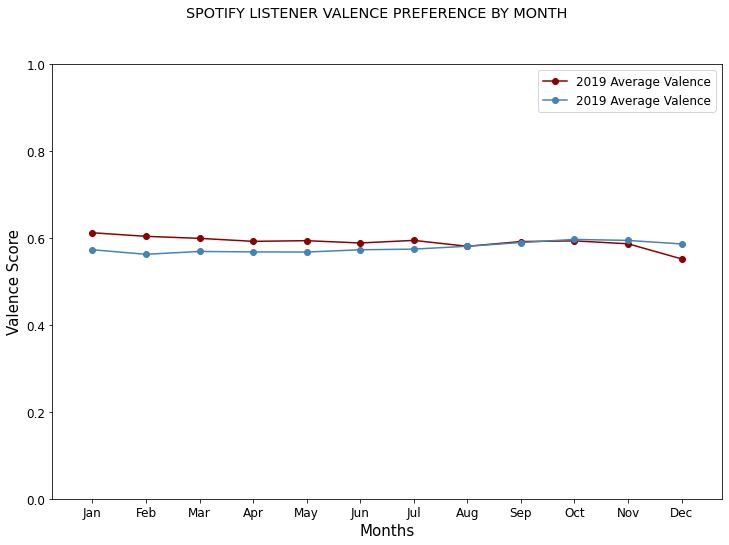

In [86]:
# Plot a comparison of 2019 2020 valence scores

# Set up lists to plot

valence_2019 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2019]
valence_2019.drop('Year', inplace=True, axis=1)
valence_2020 = country_tracks_data_groupby[country_tracks_data_groupby['Year'] == 2020]
valence_2020.drop('Year', inplace=True, axis=1)

fig= plt.figure(figsize=(12,8))                                      # Set up figure size
fig.suptitle('SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH')         # Set up main title

y_axis = valence_2019['Valence']
x_axis = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',                  # Set up x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_axis, valence_2019['Valence'], label="2019 Average Valence", marker='o', color='darkred')  # Plot 2019
plt.plot(x_axis, valence_2020['Valence'], label="2019 Average Valence", marker='o', color='steelblue')  # Plot 2020

plt.xlabel('Months')                                                 # Set up axis titles
plt.ylabel('Valence Score')

plt.xlim(-0.75, len(x_axis)-0.25)                                    # Set up axis limits
plt.ylim(0, 1)

plt.legend()                                                         # Include the legend

plt.show()


In [87]:
# Compare valence scores with covide infection rate

covid_df = pd.read_csv("input_files/owid-covid-data.csv")                # read the covid data file

country_covid_df = covid_df.loc[covid_df['location'] == 'New Zealand']   # Filter for country of your choice

country_covid_df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931


In [88]:
# Filter data for 2020, and add a 'month' column

country_covid__2020_df = country_covid_df[country_covid_df.date.str.contains(r'2020.*')]

country_covid__2020_df['Month'] = ''
country_covid__2020_df.head()

<ipython-input-88-9a7ab2cb5104>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_covid__2020_df['Month'] = ''


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,


In [89]:
# Extract the month from the 'date' column and add it to the new 'month' column, for sorting later

for index, row in country_covid__2020_df.iterrows():
    month, = re.findall(f"2020-(\d\d)-", row['date'])
    country_covid__2020_df.at[index, 'Month'] = int(month)  

country_covid__2020_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,Month
53824,NZL,Oceania,New Zealand,2020-02-28,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53825,NZL,Oceania,New Zealand,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,2
53826,NZL,Oceania,New Zealand,2020-03-01,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53827,NZL,Oceania,New Zealand,2020-03-02,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3
53828,NZL,Oceania,New Zealand,2020-03-03,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,128.797,8.08,14.8,17.2,NaN,2.61,82.29,0.931,3


In [90]:
# Create a groupby to get the sum of new cases in each month

country_covid__2020_groupby = country_covid__2020_df.groupby(['Month'], as_index=False)['new_cases'].sum()
country_covid__2020_groupby


,Month,new_cases
0,2,1.0
1,3,646.0
2,4,832.0
3,5,25.0
4,6,24.0
5,7,34.0
6,8,190.0
7,9,96.0
8,10,111.0
9,11,100.0


In [91]:
# TIP: This next section is to add missing months. In the case of New Zealand, there was no data for January
# For other countries, it might vary. Here's how I added January to the dataframe:

country_covid__2020_groupby.loc[-1] = [1, 0]             # This adds a 1 (month of January) in the first columne 
                                                         # index 0), in the last row of the dataframe. 

country_covid__2020_groupby.index = country_covid__2020_groupby.index + 1   # shifts the index
country_covid__2020_groupby = country_covid__2020_groupby.sort_index()      # sorts by index

country_covid__2020_groupby = country_covid__2020_groupby.rename(columns={"new_cases": "New Cases"})

country_covid__2020_groupby


,Month,New Cases
0,1,0.0
1,2,1.0
2,3,646.0
3,4,832.0
4,5,25.0
5,6,24.0
6,7,34.0
7,8,190.0
8,9,96.0
9,10,111.0


In [94]:
# Merge the dataframes into one nice comparison dataframe to scatter plot

country_covid_valence_df = pd.merge(valence_2020, country_covid__2020_groupby, on="Month")

country_covid_valence_df

,Month,Valence,New Cases
0,1,0.572659,0.0
1,2,0.562224,1.0
2,3,0.568755,646.0
3,4,0.567754,832.0
4,5,0.567414,25.0
5,6,0.572654,24.0
6,7,0.574170,34.0
7,8,0.580730,190.0
8,9,0.589270,96.0
9,10,0.596465,111.0


In [97]:
# Add a new cases per million column

country_polulation = 5002100  #TIP: This the population of New Zealand. Adjust for your country

country_covid_valence_df['New Cases Per Million'] = country_covid_valence_df['New Cases'] / country_polulation *1000000

country_covid_valence_df

,Month,Valence,New Cases,New Cases Per Million
0,1,0.572659,0.0,0.000000
1,2,0.562224,1.0,0.199916
2,3,0.568755,646.0,129.145759
3,4,0.567754,832.0,166.330141
4,5,0.567414,25.0,4.997901
5,6,0.572654,24.0,4.797985
6,7,0.574170,34.0,6.797145
7,8,0.580730,190.0,37.984047
8,9,0.589270,96.0,19.191939
9,10,0.596465,111.0,22.190680


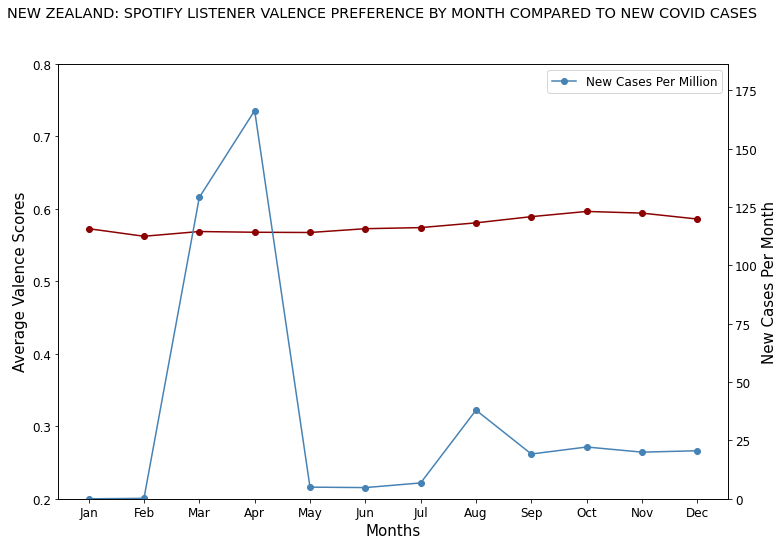

In [151]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

fig, ax1 = plt.subplots(figsize=(12,8))                   # Set up subplot figure and size
fig.suptitle('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE BY MONTH COMPARED TO NEW COVID CASES')

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',       # Set up shared x axis
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax1.set_xlabel('Months')                

ax1.set_ylabel('Average Valence Scores')                  # Set up first plot 
ax1.set_ylim([.2, .8])

ax1_ydata = country_covid_valence_df['Valence']
ax1.plot(months, ax1_ydata, label="Average Valence Scores", marker='o', color='darkred')                       
                        
ax2 = ax1.twinx()                                         # Set up second plot 
ax2.set_ylabel('New Cases Per Month')
ax2_ydata = country_covid_valence_df['New Cases Per Million']
ax2.set_ylim([0, ax2_ydata.max()+20])
ax2.plot(months, ax2_ydata, label="New Cases Per Million", marker='o', color='steelblue')


plt.legend()

plt.show()


In [114]:
# This is a mini function that adds a qualitative label to the correlation r score in the scatter plot

def r_label(r):
    abs_r = abs(r)
    if abs_r >= .8 : return "Very Strong"
    elif abs_r >= .6 : return "Strong"
    elif abs_r >= .4: return "Moderate"
    elif abs_r >= .2: return "Low"
    else: return "Negligible"

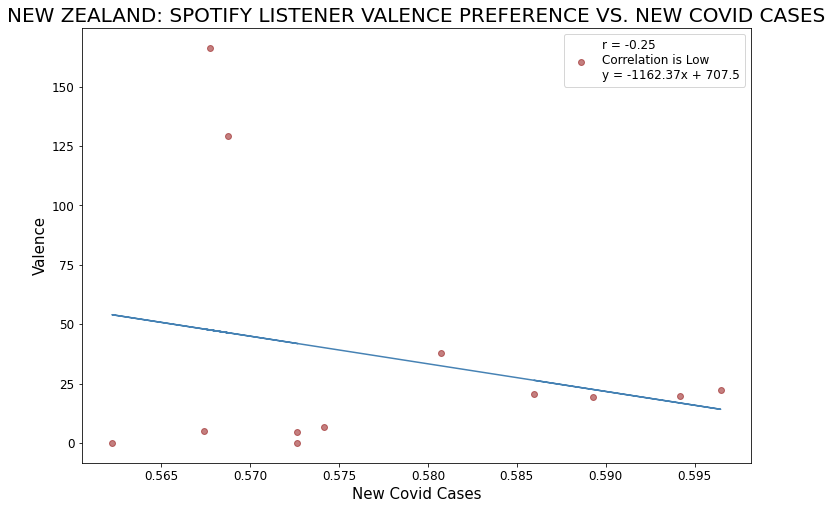

In [121]:
# Line plot relationship between Valence scores and New Cases per Million with shared x axis and duel y axes

x_axis = country_covid_valence_df['Valence']                                 # Set up axes
y_axis = country_covid_valence_df['New Cases Per Million']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x_axis, y_axis)  # Get elements of regression equation
regress_values = x_axis * slope + intercept                                  # Calculate regression values

plt.figure(figsize=(12, 8))
plt.title('NEW ZEALAND: SPOTIFY LISTENER VALENCE PREFERENCE VS. NEW COVID CASES') # CHANGE TITLE TO REFLECT YOUR COUNTRY

plt.xlabel(f"New Covid Cases")                                               # Set x axis label for subplot                  
plt.ylabel(f"Valence")                                                       # Set title for subplot

r = round(stats.pearsonr(x_axis, y_axis)[0],2)                       # Calculate correlation coefficient
rlabel = r_label(r)                                                 # Call function to create a label for the r number

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    # Ression formula

plt.scatter(x_axis, y_axis, facecolors="darkred",  alpha=.5,        # Plot the scatter chart
label=f"r = {r}\nCorrelation is {rlabel}\n{line_eq}" ) 

plt.plot(x_axis, regress_values, color="steelblue")                 # Plot the regression line    

plt.legend()                                                        # Add the legend
    
plt.savefig("output_files/valence_vs_newcases.png")                 # Save the png file   

plt.show()